In [6]:
import tensorflow as tf

model = tf.keras.models.load_model('global_model.keras')

# Show the model architecture
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                96        
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1185 (4.63 KB)
Trainable params: 1185 (4.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


exact_u shape: (256, 100)
u_star shape: (25600, 1)
u_star 2 shape: (100, 256)


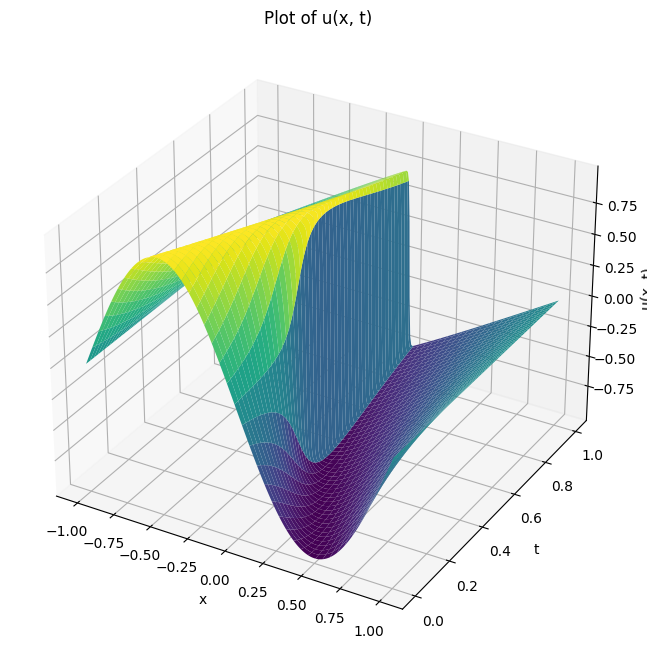

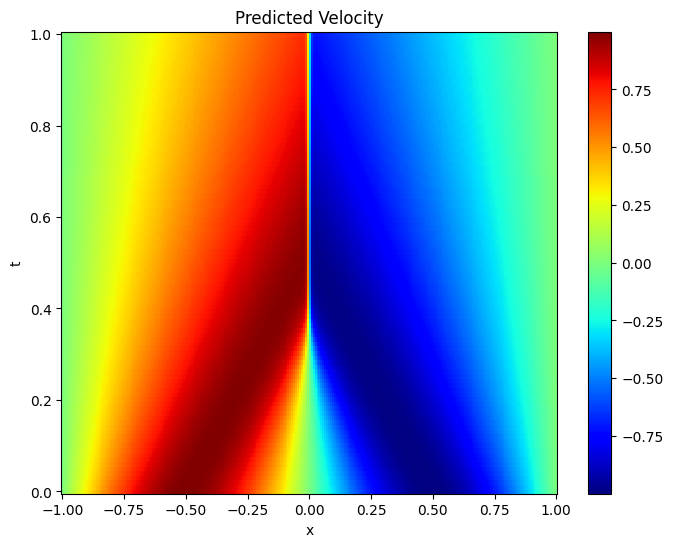

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add', 'domain_ids', 'domaindict', 'time_var', 'vars']
800/800 [==============================] - 0s 284us/step
L2 error between predicted u and actual u: 0.20507207432581626


In [7]:
import scipy
import numpy as np
import tensorflow as tf
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

class DomainND:
    def __init__(self, var, time_var=None):
        self.vars = var
        self.domaindict = []
        self.domain_ids = []
        self.time_var = time_var

    # def generate_collocation_points(self, N_f):
    #     range_list = [
    #         [val for key, val in dict_.items() if "range" in key][0]
    #         for dict_ in self.domaindict
    #     ]

    #     limits = np.array(range_list)  # x,t domain
    #     X_f = LatinHypercubeSample(N_f, limits)
    #     self.X_f = X_f

    def add(self, token, vals, fidel):
        self.domain_ids.append(token)
        self.domaindict.append({
            "identifier": token,
            "range": vals,
            (token + "fidelity"): fidel,
            (token + "linspace"): np.linspace(vals[0], vals[1], fidel),
            (token + "upper"): vals[1],
            (token + "lower"): vals[0]
        })
        
DomainND = DomainND(["x", "t"], time_var='t')

DomainND.add("x", [-1.0, 1.0], 256)
DomainND.add("t", [0.0, 1.0], 100)

# input data
data = scipy.io.loadmat('burgers_shock.mat')
Exact = data['usol']
Exact_u = np.real(Exact) # shape of [256, 100]
x = DomainND.domaindict[0]['xlinspace']
t = DomainND.domaindict[1]["tlinspace"]

X, T = np.meshgrid(x, t)

# print(np.shape((X,T))) #2, 100, 256
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None] # shape of [25600, 1]
print("exact_u shape:", Exact_u.shape)
print("u_star shape:", u_star.shape)
u_star_2 = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
print("u_star 2 shape:", u_star_2.shape)

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, T, u_star_2, cmap='viridis')
# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
plt.title('Plot of u(x, t)')
plt.show()

# 2D plotting
plt.figure(figsize=(8, 6))
plt.pcolor(X, T, u_star_2, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Velocity')
plt.show()

print(dir(DomainND))

u_pred_grid = model.predict(X_star)

l2_error = tf.sqrt(tf.reduce_mean(tf.square(u_pred_grid - u_star)))
print("L2 error between predicted u and actual u:", l2_error.numpy())

